https://github.com/teffland/Relation-Extraction/tree/master/SemEval2010_task8_all_data/SemEval2010_task8_training

https://www.depends-on-the-definition.com/attention-lstm-relation-classification/

https://github.com/tsterbak/keras_attention

https://github.com/davidsbatista/Annotated-Semantic-Relationships-Datasets

https://github.com/teffland/Relation-Extraction/tree/master/SemEval2010_task8_all_data/SemEval2010_task8_training

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

In [0]:
with open('/content/drive/My Drive/Cause_Effect/TRAIN_FILE.TXT') as f:
    train_file = f.readlines()

In [0]:
def prepare_dataset(raw):
    sentences, relations = [], []
    to_replace = [("\"", ""), ("\n", ""), ("<", " <"), (">", "> ")]
    last_was_sentence = False
    for line in raw:
        sl = line.split("\t")
        if last_was_sentence:
            relations.append(sl[0].split("(")[0].replace("\n", ""))
            last_was_sentence = False
        if sl[0].isdigit():
            sent = sl[1]
            for rp in to_replace:
                sent = sent.replace(rp[0], rp[1])
            sentences.append(sent)
            last_was_sentence = True
    print("Found {} sentences".format(len(sentences)))
    return sentences, relations

In [0]:
sentences, relations = prepare_dataset(train_file)

Found 8000 sentences


In [0]:
sentences[156]

'For those of you who are unsure what Afrikaans is, it is a language which originated from the Dutch which were the first settlers in South Africa and the unique  <e1> language </e1>  was evolved from other  <e2> settlers </e2>  from Malaya, Indonesia, Madagascar and West Africa.'

In [0]:
relations[156]

'Entity-Origin'

In [0]:
n_relations = len(set(relations))
print("Found {} relations\n".format(n_relations))
print("Relations:\n{}".format(list(set(relations))))

Found 10 relations

Relations:
['Entity-Destination', 'Message-Topic', 'Cause-Effect', 'Instrument-Agency', 'Other', 'Product-Producer', 'Member-Collection', 'Content-Container', 'Entity-Origin', 'Component-Whole']


In [0]:
def call(self, h, mask=None):
    h_shape = K.shape(h)
    d_w, T = h_shape[0], h_shape[1]
    
    logits = K.dot(h, self.w)  # w^T h
    logits = K.reshape(logits, (d_w, T))
    alpha = K.exp(logits - K.max(logits, axis=-1, keepdims=True))  # exp
    alpha = alpha / K.sum(alpha, axis=1, keepdims=True)  # softmax
    r = K.sum(h * K.expand_dims(alpha), axis=1)  # r = h*alpha^T
    h_star = K.tanh(r)  # h^* = tanh(r)
    return h_star

# Setup A Sequence Model

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin
from keras.models import Model, Input
from keras.layers import Dense, LSTM, Dropout, Embedding, SpatialDropout1D, Bidirectional, concatenate, InputSpec
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
import regex as re
import pickle
import numpy as np

from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras import backend as K

class KerasTextClassifier(BaseEstimator, TransformerMixin):
    '''Wrapper class for keras text classification models that takes raw text as input.'''
    
    def __init__(self, max_words=30000, input_length=50, emb_dim=50, n_classes=10):
        self.max_words = max_words
        self.input_length = input_length
        self.emb_dim = emb_dim
        self.n_classes = n_classes
        self.return_attention = True
        self.model = self._get_model()
        self.encoder = LabelEncoder()
        self.tokenizer = Tokenizer(num_words=self.max_words+1, filters='!"#$%&()*+,-.:;=?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token="UNK")
    
    def _get_model(self):
        d = 0.5
        rd = 0.5
        rnn_units = 128
        input_text = Input((self.input_length,))
        text_embedding = Embedding(input_dim=self.max_words + 2, output_dim=self.emb_dim,
                                   input_length=self.input_length, mask_zero=True)(input_text)
        text_embedding = SpatialDropout1D(0.5)(text_embedding)
        bilstm = Bidirectional(LSTM(units=rnn_units, return_sequences=True, dropout=d,
                                    recurrent_dropout=rd))(text_embedding)
        x, attn = AttentionWeightedAverage(return_attention=True)(bilstm)
        x = Dropout(0.5)(x)
        out = Dense(units=self.n_classes, activation="softmax")(x)
        model = Model(input_text, out)
        return model
    
    def _get_attention_map(self, texts):
        att_model_output = self.model.layers[0:-2]
        att_model = Model(att_model_output[0].input, att_model_output[-1].output)
        att_model.compile(optimizer=RMSprop(),
                          loss="sparse_categorical_crossentropy",
                          metrics=["accuracy"])
        return att_model.predict(self._get_sequences(texts))[1]
    
    def _get_sequences(self, texts):
        seqs = self.tokenizer.texts_to_sequences(texts)
        return pad_sequences(seqs, maxlen=self.input_length,
                             value=0, padding='post', truncating='post')
    
    def _labels(self, labels):
        return self.encoder.transform(labels)
    
    def fit(self, X, y, X_val=None, y_val=None, lr=0.001, resume=False,
            epochs=10, batch_size=32):
        '''
        Fit the vocabulary and the model.
        
        :params:
        X: list of texts
        y: labels
        X_val: list of texts for validation
        y_val: labels for validation.
        '''
        self.model.compile(optimizer=RMSprop(clipnorm=10., lr=lr),
                           loss="sparse_categorical_crossentropy",
                           metrics=["accuracy"])
        
        if not resume:
            self.tokenizer.fit_on_texts(X)
            self.encoder.fit(y)
            self.tokenizer.word_index = {e: i for e,i in self.tokenizer.word_index.items() if i <= self.max_words}
            self.tokenizer.word_index[self.tokenizer.oov_token] = self.max_words + 1
        else:
            print("Resuming training...")
        seqs = self._get_sequences(X)
        categorical_y = self._labels(y)
        print("Fit text model with {} classes".format(len(self.encoder.classes_)))
        if X_val:
            val_seqs = self._get_sequences(X_val)
            categorical_y_val = self._labels(y_val)
            self.model.fit(seqs, categorical_y, batch_size=batch_size,
                           epochs=epochs, validation_data=(val_seqs, categorical_y_val))
        else:
            self.model.fit(seqs, categorical_y, batch_size=batch_size,
                           epochs=epochs, validation_split=0.1)
    
    def predict_proba(self, X, y=None):
        return self.model.predict(self._get_sequences(X))
    
    def predict(self, X, y=None):
        return np.argmax(self.predict_proba(X), axis=1)
    
    def save(self, path="model"):                               
        self.model.save_weights('{}_weights.h5'.format(path))          
        with open("{}_index.pkl".format(path), "wb") as f:                      
            pickle.dump([self.encoder, self.tokenizer, self.max_words,
                         self.emb_dim, self.input_length, self.n_classes], f)         
            
    def load(self, path="model"):                                                              
        with open("{}_index.pkl".format(path), "rb") as f:
            self.encoder, self.tokenizer, self.max_words, self.emb_dim, self.input_length, self.n_classes = pickle.load(f)                                                                     
        self.model = self._get_model()                                           
        self.model.load_weights('{}_weights.h5'.format(path))
        
        
class AttentionWeightedAverage(Layer):
    """
    Computes a weighted average attention mechanism from:
        Zhou, Peng, Wei Shi, Jun Tian, Zhenyu Qi, Bingchen Li, Hongwei Hao and Bo Xu.
        “Attention-Based Bidirectional Long Short-Term Memory Networks for Relation Classification.”
        ACL (2016). http://www.aclweb.org/anthology/P16-2034
    How to use:
    see: [BLOGPOST]
    """

    def __init__(self, return_attention=False, **kwargs):
        self.init = initializers.get('uniform')
        self.supports_masking = True
        self.return_attention = return_attention
        super(AttentionWeightedAverage, self).__init__(** kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(ndim=3)]
        assert len(input_shape) == 3

        self.w = self.add_weight(shape=(input_shape[2], 1),
                                 name='{}_w'.format(self.name),
                                 initializer=self.init)
        self.trainable_weights = [self.w]
        super(AttentionWeightedAverage, self).build(input_shape)

    def call(self, h, mask=None):
        h_shape = K.shape(h)
        d_w, T = h_shape[0], h_shape[1]
        
        logits = K.dot(h, self.w)  # w^T h
        logits = K.reshape(logits, (d_w, T))
        alpha = K.exp(logits - K.max(logits, axis=-1, keepdims=True))  # exp
        
        # masked timesteps have zero weight
        if mask is not None:
            mask = K.cast(mask, K.floatx())
            alpha = alpha * mask
        alpha = alpha / K.sum(alpha, axis=1, keepdims=True) # softmax
        r = K.sum(h * K.expand_dims(alpha), axis=1)  # r = h*alpha^T
        h_star = K.tanh(r)  # h^* = tanh(r)
        if self.return_attention:
            return [h_star, alpha]
        return h_star

    def get_output_shape_for(self, input_shape):
        return self.compute_output_shape(input_shape)

    def compute_output_shape(self, input_shape):
        output_len = input_shape[2]
        if self.return_attention:
            return [(input_shape[0], output_len), (input_shape[0], input_shape[1])]
        return (input_shape[0], output_len)

    def compute_mask(self, input, input_mask=None):
        if isinstance(input_mask, list):
            return [None] * len(input_mask)
        else:
            return None

Using TensorFlow backend.


In [0]:
import numpy as np
from sklearn.model_selection import train_test_split

In [0]:
kclf = KerasTextClassifier(input_length=50, n_classes=n_relations, max_words=15000)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
tr_sent, te_sent, tr_rel, te_rel = train_test_split(sentences, relations, test_size=0.1)

In [0]:
kclf.fit(X=tr_sent, y=tr_rel, X_val=te_sent, y_val=te_rel,
         batch_size=10, lr=0.001, epochs=20)

Fit text model with 10 classes
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 7200 samples, validate on 800 samples
Epoch 1/20
7200/7200 [==============================] - 84s 12ms/step - loss: 2.1416 - acc: 0.2254 - val_loss: 1.8688 - val_acc: 0.3300
Epoch 2/20
7200/7200 [==============================] - 82s 11ms/step - loss: 1.8603 - acc: 0.3267 - val_loss: 1.6375 - val_acc: 0.4238
Epoch 3/20
7200/7200 [==============================] - 81s 11ms/step - loss: 1.6610 - acc: 0.4019 - val_loss: 1.5092 - val_acc: 0.4475
Epoch 4/20
7200/7200 [==============================] - 82s 11ms/step - loss: 1.5400 - acc: 0.4403 - val_loss: 1.4122 - val_acc: 0.4800
Epoch 5/20
7200/7200 [==============================] - 82s 11ms/step - loss: 1.3978 - acc: 0.4918 - val_loss: 1.3811 - val_acc: 0.5138
Epoch 6/20
7200/7200 [==============================] - 82s 11ms/step - loss: 1.3143 - acc: 0.5318 - val_loss: 1.305

# Investigate Attention

In [0]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

In [0]:
y_pred = kclf.predict(te_sent)
y_attn = kclf._get_attention_map(te_sent)

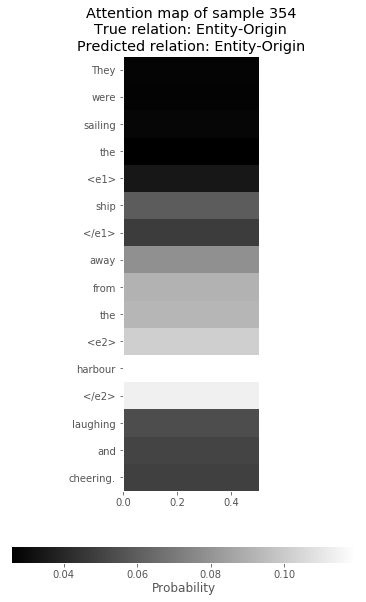

In [0]:
i = 354
activation_map = np.expand_dims(y_attn[i][:len(te_sent[i].split())], axis=1)

f = plt.figure(figsize=(8, 8))
ax = f.add_subplot(1, 1, 1)

img = ax.imshow(activation_map, interpolation='none', cmap='gray')

plt.xlim([0,0.5])
ax.set_aspect(0.1)
ax.set_yticks(range(len(te_sent[i].split())))
ax.set_yticklabels(te_sent[i].split());
ax.grid()
plt.title("Attention map of sample {}\nTrue relation: {}\nPredicted relation: {}"
          .format(i, te_rel[i], kclf.encoder.classes_[y_pred[i]]));

# add colorbar
cbaxes = f.add_axes([0.2, 0, 0.6, 0.03]);
cbar = f.colorbar(img, cax=cbaxes, orientation='horizontal');
cbar.ax.set_xlabel('Probability', labelpad=2);

# Evaluate The Model

In [0]:
from sklearn.metrics import f1_score, classification_report, accuracy_score

In [0]:
y_test_pred = kclf.predict(te_sent)

In [0]:
label_idx_to_use = [i for i, c in enumerate(list(kclf.encoder.classes_)) if  c !="Other"]
label_to_use = list(kclf.encoder.classes_)
label_to_use.remove("Other")

In [0]:
print("F1-Score: {:.1%}".format(f1_score(kclf.encoder.transform(te_rel), y_test_pred, average="macro", labels=label_idx_to_use)))

F1-Score: 69.9%


In [0]:
print(classification_report(kclf.encoder.transform(te_rel), y_test_pred, target_names=label_to_use, labels=label_idx_to_use))

                    precision    recall  f1-score   support

      Cause-Effect       0.84      0.77      0.80       101
   Component-Whole       0.59      0.62      0.60        97
 Content-Container       0.81      0.67      0.73        51
Entity-Destination       0.80      0.90      0.85        94
     Entity-Origin       0.70      0.76      0.73        68
 Instrument-Agency       0.57      0.68      0.62        47
 Member-Collection       0.89      0.72      0.80        69
     Message-Topic       0.54      0.56      0.55        52
  Product-Producer       0.53      0.71      0.60        68

         micro avg       0.69      0.72      0.71       647
         macro avg       0.70      0.71      0.70       647
      weighted avg       0.71      0.72      0.71       647

